# Titanic Data Exploration

## Table of Contents
* Overview
* Initial Exploration and Plotting
* Exploratory Analysis by Variable
    * Names
    * Families
    * Tickets
    * Fares
    * Cabins
    * Embarkment
    * Ages

In [334]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sns
import pandas as pd
import numpy as np

%matplotlib inline

train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

## Initial Exploration and Plotting

In [3]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 35.9+ KB


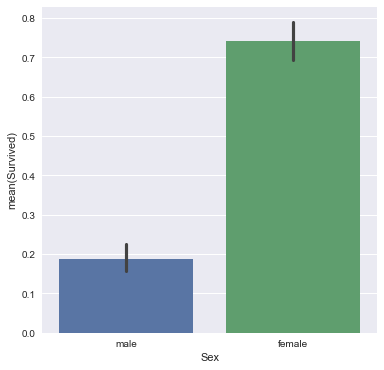

In [362]:
plt.figure(1, figsize=(6, 6))
sns.barplot(x='Sex', y='Survived', data=train)
plt.show()

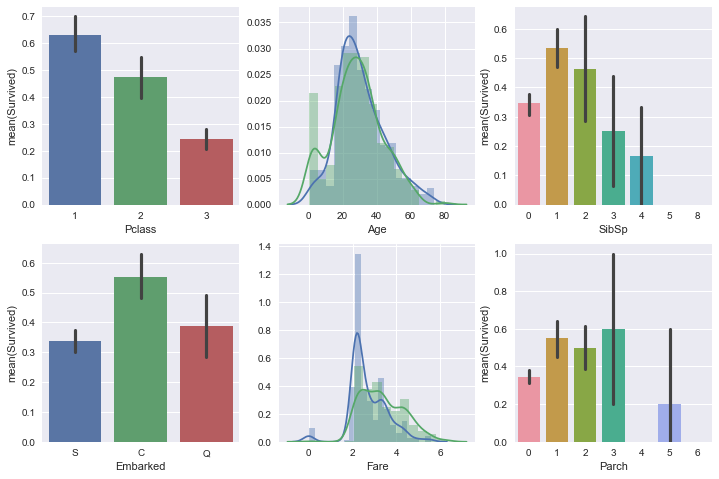

In [343]:
s_ages = train.loc[train['Survived'] == 1, 'Age'].dropna()
d_ages = train.loc[train['Survived'] == 0, 'Age'].dropna()
s_fares = train.loc[train['Survived'] == 1, 'Fare'].add(1).apply(np.log).dropna()
d_fares = train.loc[train['Survived'] == 0, 'Fare'].add(1).apply(np.log).dropna()

plt.figure(2, figsize=(12, 8))
plt.subplot(231)
sns.barplot(x='Pclass', y='Survived', data=train)
plt.subplot(234)
sns.barplot(x='Embarked', y='Survived', data=train)
plt.subplot(233)
sns.barplot(x='SibSp', y='Survived', data=train)
plt.subplot(236)
sns.barplot(x='Parch', y='Survived', data=train)
plt.subplot(232)
sns.distplot(d_ages, color='C0')
sns.distplot(s_ages, color='C1')
plt.subplot(235)
sns.distplot(d_fares, color='C0')
sns.distplot(s_fares, color='C1')
plt.show()

## Exploratory Analysis and Feature Engineering
Here, we'll explore the features of the dataset. Since `Sex` and `PClass` are rather clear-cut and have been explored in many other kernels, we will not explore those for now. We'll explore the related features `SibSp` and `Parch` together, as a "family size" feature group. Due to the large amount of missing values for `Age`, we will explore it last - after looking at the other features, we may come up with strategies for imputation.

Finally, we'll create several derived features if necessary.

### Names
This doesn't seem like a very promising feature, but take a look:

In [351]:
train['Name'].head()

PassengerId
1                              Braund, Mr. Owen Harris
2    Cumings, Mrs. John Bradley (Florence Briggs Th...
3                               Heikkinen, Miss. Laina
4         Futrelle, Mrs. Jacques Heath (Lily May Peel)
5                             Allen, Mr. William Henry
Name: Name, dtype: object

The names look very consistently formatted, in the form of (last), (title). (first) (middle)
Since there are only a handful of distinct titles (versus the largely unique names), we'll extract this information:

In [352]:
train['Title'] = train['Name'].str.extract('\,\s(.*?)[.]', expand=False)
print(train['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer']


In [353]:
test['Title'] = test['Name'].str.extract('\,\s(.*?)[.]', expand=False)
print(test['Title'].unique())

['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


To start with, let's get an idea of how many passengers are holding each title.

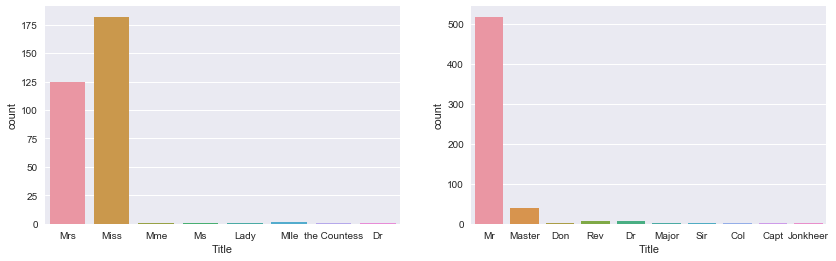

In [366]:
plt.figure(3, figsize=(14, 4))
plt.subplot(121)
sns.countplot(train.loc[train['Sex'] == 'female', 'Title'])
plt.subplot(122)
sns.countplot(train.loc[train['Sex'] == 'male', 'Title'])
plt.show()

The low number of most of the titles suggest grouping up the more esoteric ones. We'll do so as follows (there are no hard rules, so we'll use some judgment):

* Merge Mme. into Mrs. and Mlle. into Miss.
* Merge Lady, the Countess, and Dona (from the test set) into a category of noblewomen.
* Merge Don, Sir, and Jonkheer into a category of noblemen.
* Merge Col, Capt, and Major into a category of military.

For 'Ms.', we'll look at the woman's age, and also check her party.

In [121]:
train[train['Title'] == 'Ms']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
444,1,2,"Reynaldo, Ms. Encarnacion",female,28.0,0,0,230434,13.0,NaN,S,Ms


Since she is relatively young and traveling alone, we'll throw her in with the "Miss" group.

In [359]:
title_map = {'Mr': 'Mr',
             'Mrs': 'Mrs',
             'Miss': 'Miss',
             'Master': 'Master',
             'Dr': 'Dr',
             'Rev': 'Rev',
             'Don': 'mnoble',
             'Sir': 'mnoble',
             'Jonkheer': 'mnoble',
             'Lady': 'fnoble',
             'the Countess': 'fnoble',
             'Dona': 'fnoble',
             'Col': 'mil',
             'Capt': 'mil',
             'Major': 'mil',
             'Mme': 'Mrs',
             'Mlle': 'Miss',
             'Ms': 'Miss'}

train['AdjTitle'] = train['Title'].map(title_map)
test['AdjTitle'] = test['Title'].map(title_map)

Let's see how these titles did:

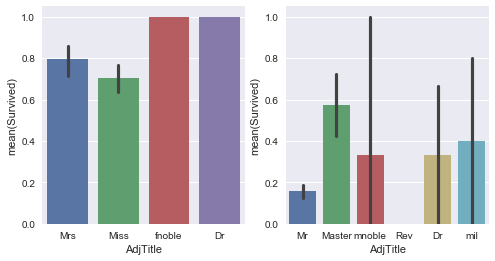

In [365]:
plt.figure(4, figsize=(8, 4))
plt.subplot(121)
sns.barplot(x='AdjTitle', y='Survived', data=train[train['Sex'] == 'female'])
plt.subplot(122)
sns.barplot(x='AdjTitle', y='Survived', data=train[train['Sex'] == 'male'])
plt.show()

For women, it seems pretty clear-cut: The women with nobility titles survived (as did women on the whole). The men with titles (all except Rev.) seem to do better on average, but it's highly variable. Since the gender-based model where all women live and men die attains over a 76% accuracy, the hard part of our model seems to be picking out the few male survivors.

### Family Size

Here we'll work with the `SibSp` and `Parch` features, which involve family size. To look for lone travelers, we'll first look at the distribution of the features added together, separated by gender:

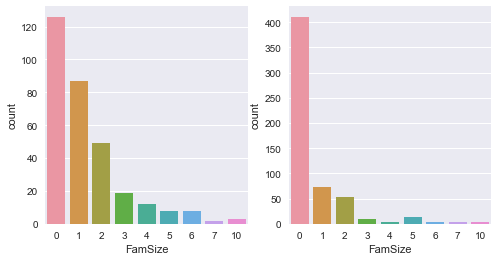

In [364]:
train['FamSize'] = train['SibSp'] + train['Parch']
test['FamSize'] = test['SibSp'] + test['Parch']

plt.figure(5, figsize=(8, 4))
plt.subplot(121)
sns.countplot(train.loc[train['Sex'] == 'female', 'FamSize'])
plt.subplot(122)
sns.countplot(train.loc[train['Sex'] == 'male', 'FamSize'])
plt.show()

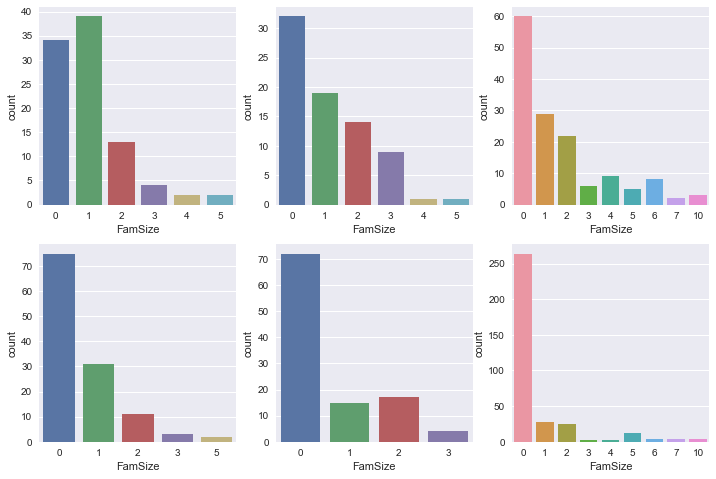

In [367]:
train['FamSize'] = train['SibSp'] + train['Parch']
test['FamSize'] = test['SibSp'] + test['Parch']

plt.figure(6, figsize=(12, 8))
plt.subplot(231)
sns.countplot(train.loc[(train['Sex'] == 'female') & (train['Pclass'] == 1), 'FamSize'])
plt.subplot(234)
sns.countplot(train.loc[(train['Sex'] == 'male') & (train['Pclass'] == 1), 'FamSize'])
plt.subplot(232)
sns.countplot(train.loc[(train['Sex'] == 'female') & (train['Pclass'] == 2), 'FamSize'])
plt.subplot(235)
sns.countplot(train.loc[(train['Sex'] == 'male') & (train['Pclass'] == 2), 'FamSize'])
plt.subplot(233)
sns.countplot(train.loc[(train['Sex'] == 'female') & (train['Pclass'] == 3), 'FamSize'])
plt.subplot(236)
sns.countplot(train.loc[(train['Sex'] == 'male') & (train['Pclass'] == 3), 'FamSize'])
plt.show()

How did this impact survival?

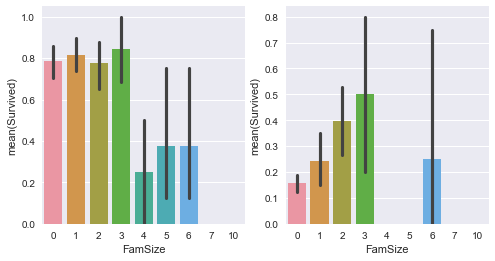

In [368]:
plt.figure(7, figsize=(8, 4))
plt.subplot(121)
sns.barplot(x='FamSize', y='Survived', data=train[train['Sex'] == 'female'])
plt.subplot(122)
sns.barplot(x='FamSize', y='Survived', data=train[train['Sex'] == 'male'])
plt.show()

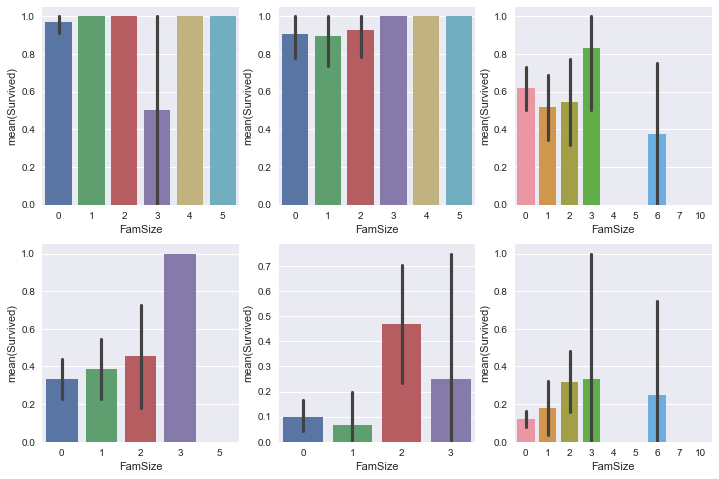

In [369]:
plt.figure(9, figsize=(12, 8))
plt.subplot(231)
sns.barplot(x='FamSize', y='Survived', data=train[(train['Sex'] == 'female') & (train['Pclass'] == 1)])
plt.subplot(234)
sns.barplot(x='FamSize', y='Survived', data=train[(train['Sex'] == 'male') & (train['Pclass'] == 1)])
plt.subplot(232)
sns.barplot(x='FamSize', y='Survived', data=train[(train['Sex'] == 'female') & (train['Pclass'] == 2)])
plt.subplot(235)
sns.barplot(x='FamSize', y='Survived', data=train[(train['Sex'] == 'male') & (train['Pclass'] == 2)])
plt.subplot(233)
sns.barplot(x='FamSize', y='Survived', data=train[(train['Sex'] == 'female') & (train['Pclass'] == 3)])
plt.subplot(236)
sns.barplot(x='FamSize', y='Survived', data=train[(train['Sex'] == 'male') & (train['Pclass'] == 3)])
plt.show()

Let's ignore (for the moment) possible effects from passenger class. We can then draw the following conclusions:

* Most men traveled alone. Those with families were generally in smaller ones. A huge amount of men traveled alone in third class; they had very low survival chances.
* Many women traveled alone, but not as many as men. Larger groups consisted of mostly women.
* In first and second class:
    * Women seem to have roughly the same survival chance, independent of family size.
    * Men with larger family sizes seem to have relatively higher chances of survival.
* In third class:
    * Women and men seem to have relatively higher chances of survival, up to a family size of 3.
    * Women and men with a family size of 4 or higher had drastically lower odds of survival.

### Tickets
One thing we can do with ticket numbers is scan for duplicates:

In [283]:
ticket_dupes = train[(train['Ticket'].duplicated(keep=False))].set_index('Ticket', append=True).swaplevel(0, 1).sort_index()
ticket_dupes

Survived  Pclass  \
Ticket           PassengerId                     
110152           258                 1       1   
                 505                 1       1   
                 760                 1       1   
110413           263                 0       1   
                 559                 1       1   
                 586                 1       1   
110465           111                 0       1   
                 476                 0       1   
111361           330                 1       1   
                 524                 1       1   
113505           167                 1       1   
                 357                 1       1   
113572           62                  1       1   
                 830                 1       1   
113760           391                 1       1   
                 436                 1       1   
                 764                 1       1   
                 803                 1       1   
113776           152                 1       1   
                 337                 0       1   
113781           298                 0       1   
                 306                 1       1   
                 499                 0       1   
                 709                 1       1   
113789           36                  0       1   
                 384                 1       1   
113798           271                 0       1   
                 843                 1       1   
113803           4                   1       1   
                 138                 0       1   
...                                ...     ...   
PC 17758         506                 0       1   
PC 17760         270                 1       1   
                 326                 1       1   
                 374                 0       1   
PC 17761         538                 1       1   
                 545                 0       1   
PP 9549          11                  1       3   
                 395                 1       3   
S.C./PARIS 2079  818                 0       2   
                 828                 1       2   
S.O./P.P. 3      773                 0       2   
                 842                 0       2   
S.O.C. 14879     73                  0       2   
                 121                 0       2   
                 386                 0       2   
                 656                 0       2   
                 666                 0       2   
SC/Paris 2123    44                  1       2   
                 609                 1       2   
                 686                 0       2   
STON/O2. 3101279 143                 1       3   
                 404                 0       3   
W./C. 6607       784                 0       3   
                 889                 0       3   
W./C. 6608       87                  0       3   
                 148                 0       3   
                 437                 0       3   
                 737                 0       3   
WE/P 5735        541                 1       1   
                 746                 0       1   

                                                                           Name  \
Ticket           PassengerId                                                      
110152           258                                       Cherry, Miss. Gladys   
                 505                                      Maioni, Miss. Roberta   
                 760          Rothes, the Countess. of (Lucy Noel Martha Dye...   
110413           263                                          Taussig, Mr. Emil   
                 559                     Taussig, Mrs. Emil (Tillie Mandelbaum)   
                 586                                        Taussig, Miss. Ruth   
110465           111                             Porter, Mr. Walter Chamberlain   
                 476                                Clifford, Mr. George Quincy   
111361           330                             

We can check whether holders of duplicate tickets are likely to share cabins, fares, family size and embark location.

In [290]:
dupe_counts = ticket_dupes.reset_index().groupby('Ticket')[['Fare', 'Cabin', 'Embarked', 'FamSize']].nunique()
dupe_counts.describe()

,Fare,Cabin,Embarked,FamSize
count,134.000000,134.000000,134.000000,134.000000
mean,1.007463,0.537313,1.007463,1.201493
std,0.086387,0.742448,0.150001,0.402620
min,1.000000,0.000000,0.000000,1.000000
25%,1.000000,0.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000
max,2.000000,3.000000,2.000000,2.000000


It seems like most of them did. Let's take a look at the fares:

In [304]:
ticket_dupes.loc[dupe_counts[dupe_counts['Fare'] > 1].index.values]

Survived  Pclass                           Name   Sex  \
Ticket PassengerId                                                          
7534   139                 0       3            Osen, Mr. Olaf Elon  male   
       877                 0       3  Gustafsson, Mr. Alfred Ossian  male   

                     Age  SibSp  Parch    Fare Cabin Embarked Title PTitle  \
Ticket PassengerId                                                           
7534   139          16.0      0      0  9.2167   NaN        S    Mr     Mr   
       877          20.0      0      0  9.8458   NaN        S    Mr     Mr   

                    Child  TicketSize  AdjFare   LogFare AdjTitle  FamSize  
Ticket PassengerId                                                          
7534   139          False           2  4.60835  1.724257       Mr        0  
       877          False           2  4.92290  1.778826       Mr        0

Only one pair of fares that are different (and not by much). For all we know, this could be an entry error, but let's ignore this for now. Let's look at embark locations:

In [306]:
ticket_dupes.loc[dupe_counts[dupe_counts['Embarked'] > 1].index.values]

Survived  Pclass                      Name     Sex  \
Ticket   PassengerId                                                       
113798   271                 0       1     Cairns, Mr. Alexander    male   
         843                 1       1   Serepeca, Miss. Augusta  female   
PC 17760 270                 1       1    Bissette, Miss. Amelia  female   
         326                 1       1  Young, Miss. Marie Grice  female   
         374                 0       1       Ringhini, Mr. Sante    male   

                       Age  SibSp  Parch      Fare Cabin Embarked Title  \
Ticket   PassengerId                                                      
113798   271           NaN      0      0   31.0000   NaN        S    Mr   
         843          30.0      0      0   31.0000   NaN        C  Miss   
PC 17760 270          35.0      0      0  135.6333   C99        S  Miss   
         326          36.0      0      0  135.6333   C32        C  Miss   
         374          22.0      0      0  135.6333   NaN        C    Mr   

                     PTitle  Child  TicketSize  AdjFare  LogFare AdjTitle  \
Ticket   PassengerId                                                        
113798   271             Mr  False           2  15.5000  2.80336       Mr   
         843           Miss  False           2  15.5000  2.80336     Miss   
PC 17760 270           Miss  False           3  45.2111  3.83322     Miss   
         326           Miss  False           3  45.2111  3.83322     Miss   
         374             Mr  False           3  45.2111  3.83322       Mr   

                      FamSize  
Ticket   PassengerId           
113798   271                0  
         843                0  
PC 17760 270                0  
         326                0  
         374                0

Only two! Though these could be mistakes, it is plausible that they did board at different locations, since they do not appear related to each other. Let's look at the last two variables:

In [307]:
ticket_dupes.loc[dupe_counts[dupe_counts['FamSize'] > 1].index.values]

Survived  Pclass  \
Ticket       PassengerId                     
113781       298                 0       1   
             306                 1       1   
             499                 0       1   
             709                 1       1   
11767        311                 1       1   
             880                 1       1   
12749        521                 1       1   
             821                 1       1   
13502        276                 1       1   
             628                 1       1   
             766                 1       1   
16966        320                 1       1   
             338                 1       1   
17421        307                 1       1   
             551                 1       1   
             582                 1       1   
             699                 0       1   
19877        291                 1       1   
             742                 0       1   
19928        246                 0       1   
             413                 1       1   
24160        690                 1       1   
             731                 1       1   
             780                 1       1   
243847       218                 0       2   
             601                 1       2   
248727       597                 1       2   
             721                 1       2   
             849                 0       2   
29106        408                 1       2   
...                            ...     ...   
371110       518                 0       3   
             769                 0       3   
A/4 48871    566                 0       3   
             812                 0       3   
PC 17485     310                 1       1   
             600                 1       1   
PC 17569     32                  1       1   
             196                 1       1   
PC 17572     53                  1       1   
             646                 1       1   
             682                 1       1   
PC 17582     269                 1       1   
             333                 0       1   
             610                 1       1   
PC 17611     335                 1       1   
             661                 1       1   
PC 17755     259                 1       1   
             680                 1       1   
             738                 1       1   
PC 17757     381                 1       1   
             558                 0       1   
             701                 1       1   
             717                 1       1   
PC 17761     538                 1       1   
             545                 0       1   
S.O.C. 14879 73                  0       2   
             121                 0       2   
             386                 0       2   
             656                 0       2   
             666                 0       2   

                                                                       Name  \
Ticket       PassengerId                                                      
113781       298                               Allison, Miss. Helen Loraine   
             306                             Allison, Master. Hudson Trevor   
             499            Allison, Mrs. Hudson J C (Bessie Waldo Daniels)   
             709                                       Cleaver, Miss. Alice   
11767        311                             Hays, Miss. Margaret Bechstein   
             880              Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)   
12749        521                                      Perreault, Miss. Anne   
             821          Hays, Mrs. Charles Melville (Clara Jennings Gr...   
13502        276                          Andrews, Miss. Kornelia Theodosia   
             628                              Longley, Miss. Gretchen Fiske   
             766                       Hogeboom, Mrs. John C (Anna Andrews)   
16966        320          Spedden, Mrs. Frederic Oakley (Margaretta Corn...   
             338     

In [308]:
ticket_dupes.loc[dupe_counts[dupe_counts['Cabin'] > 1].index.values]

Survived  Pclass  \
Ticket   PassengerId                     
110152   258                 1       1   
         505                 1       1   
         760                 1       1   
110413   263                 0       1   
         559                 1       1   
         586                 1       1   
110465   111                 0       1   
         476                 0       1   
11767    311                 1       1   
         880                 1       1   
12749    521                 1       1   
         821                 1       1   
13502    276                 1       1   
         628                 1       1   
         766                 1       1   
16966    320                 1       1   
         338                 1       1   
17421    307                 1       1   
         551                 1       1   
         582                 1       1   
         699                 0       1   
24160    690                 1       1   
         731                 1       1   
         780                 1       1   
35273    216                 1       1   
         394                 1       1   
         660                 0       1   
PC 17485 310                 1       1   
         600                 1       1   
PC 17569 32                  1       1   
         196                 1       1   
PC 17572 53                  1       1   
         646                 1       1   
         682                 1       1   
PC 17582 269                 1       1   
         333                 0       1   
         610                 1       1   
PC 17593 140                 0       1   
         790                 0       1   
PC 17755 259                 1       1   
         680                 1       1   
         738                 1       1   
PC 17757 381                 1       1   
         558                 0       1   
         701                 1       1   
         717                 1       1   
PC 17760 270                 1       1   
         326                 1       1   
         374                 0       1   

                                                                   Name  \
Ticket   PassengerId                                                      
110152   258                                       Cherry, Miss. Gladys   
         505                                      Maioni, Miss. Roberta   
         760          Rothes, the Countess. of (Lucy Noel Martha Dye...   
110413   263                                          Taussig, Mr. Emil   
         559                     Taussig, Mrs. Emil (Tillie Mandelbaum)   
         586                                        Taussig, Miss. Ruth   
110465   111                             Porter, Mr. Walter Chamberlain   
         476                                Clifford, Mr. George Quincy   
11767    311                             Hays, Miss. Margaret Bechstein   
         880              Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)   
12749    521                                      Perreault, Miss. Anne   
         821          Hays, Mrs. Charles Melville (Clara Jennings Gr...   
13502    276                          Andrews, Miss. Kornelia Theodosia   
         628                              Longley, Miss. Gretchen Fiske   
         766                       Hogeboom, Mrs. John C (Anna Andrews)   
16966    320          Spedden, Mrs. Frederic Oakley (Margaretta Corn...   
         338                            Burns, Miss. Elizabeth Margaret   
17421    307                                    Fleming, Miss. Margaret   
         551                                Thayer, Mr. John Borland Jr   
         582          Thayer, Mrs. John Borland (Marian Longstreth M...   
         699                                   Thayer, Mr. John Borland   
24160    690                          Madill, Miss. Georgette Alexandra   
         731                              Allen, Miss. Elisabeth Walton   
    

We have many more duplicate values here; it's plausible different families could split tickets, or bring servants/maids. Also, for family size, it's worth remembering that non-married partners do not count toward `SibSp`.

### Fares
We see that Fare is a highly right-skewed variable.

<IPython.core.display.Javascript object>


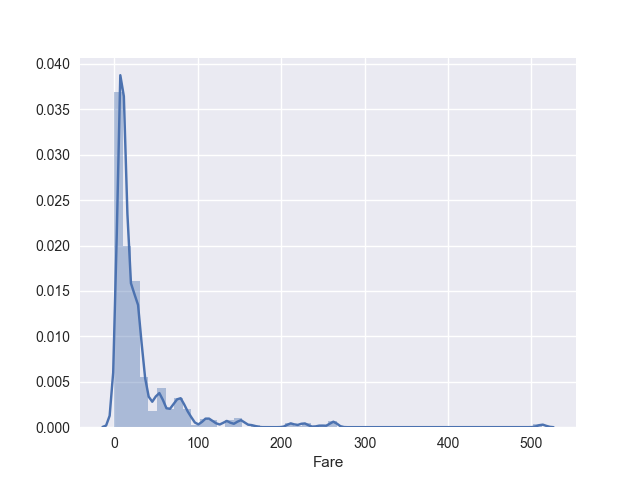

4.7792532923723545

In [315]:
plt.figure(10)
sns.distplot(train['Fare'])
plt.show()
st.skew(train['Fare'])

Let's look at the outliers values that are above 200...

In [323]:
train[train['Fare'] > 200]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PTitle,Child,TicketSize,AdjFare,LogFare,AdjTitle,FamSize
PassengerId,,,,,,,,,,,,,,,,,,,
28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S,Mr,Mr,False,4,65.750000,4.200954,Mr,5
89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S,Miss,Miss,False,4,65.750000,4.200954,Miss,5
119,0,1,"Baxter, Mr. Quigg Edmond",male,24.0,0,1,PC 17558,247.5208,B58 B60,C,Mr,Mr,False,2,123.760400,4.826395,Mr,1
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C,Miss,Miss,False,3,170.776400,5.146194,Miss,0
300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.0,0,1,PC 17558,247.5208,B58 B60,C,Mrs,Mrs,False,2,123.760400,4.826395,Mrs,1
312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,Miss,Miss,False,2,131.187500,4.884221,Miss,4
342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,Miss,Miss,False,4,65.750000,4.200954,Miss,5
378,0,1,"Widener, Mr. Harry Elkins",male,27.0,0,2,113503,211.5000,C82,C,Mr,Mr,False,1,211.500000,5.358942,Mr,2
381,1,1,"Bidois, Miss. Rosalie",female,42.0,0,0,PC 17757,227.5250,NaN,C,Miss,Miss,False,4,56.881250,4.058393,Miss,0


We see that almost all of the fares have shared cabins and shared tickets. Let's test the theory that 'Fare' refers to a group fare of all tickets with the same number, rather than fare per ticket:

In [371]:
train['TicketSize'] = train['Ticket'].value_counts()[train['Ticket']].values
test['TicketSize'] = test['Ticket'].value_counts()[test['Ticket']].values

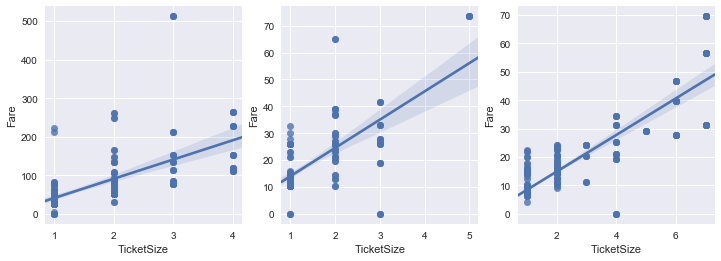

In [372]:
plt.figure(11, figsize=(12, 4))
plt.subplot(131)
sns.regplot(x='TicketSize', y='Fare', data=train[train['Pclass'] == 1])
plt.subplot(132)
sns.regplot(x='TicketSize', y='Fare', data=train[train['Pclass'] == 2])
plt.subplot(133)
sns.regplot(x='TicketSize', y='Fare', data=train[train['Pclass'] == 3])
plt.show()

Let's assume that it is linear. We'll divide by the ticket size, and look at the skew for each class:

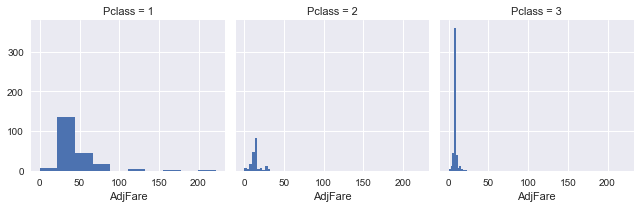

Pclass
1    3.120576
2    1.040021
3    2.319343
Name: AdjFare, dtype: float64

In [373]:
train['AdjFare'] = train['Fare'].div(train['TicketSize'])
g = sns.FacetGrid(train, col='Pclass')
g = g.map(plt.hist, 'AdjFare')
plt.show()
train.groupby('Pclass')['AdjFare'].apply(st.skew)

This is still somewhat right skewed. If we want, we can later use a square root transform; however, for now, we will leave the Fare as is.

### Cabins
Only a fraction of the passengers have known cabin information. We'll create a feature called `CabinKnown` that indicates if the cabin is given. Let's see if a known cabin is related to survival:

In [11]:
train['CabinKnown'] = train['Cabin'].notnull()
pd.crosstab(train['CabinKnown'], train['Survived'])

Survived,0,1
CabinKnown,,
False,481,206
True,68,136


In [39]:
plt.figure(2)
sns.barplot(x='CabinKnown', y='Survived', data=train)
plt.show()

Let's also search for duplicate cabins, since that may indicate party size and help impute missing values.

In [14]:
train[(train['Cabin'].duplicated(keep=False)) & (train['Cabin'].notnull())].set_index('Cabin', append=True).swaplevel(0, 1).sort_index()

Survived  Pclass  \
Cabin           PassengerId                     
B18             330                 1       1   
                524                 1       1   
B20             691                 1       1   
                782                 1       1   
B22             541                 1       1   
                746                 0       1   
B28             62                  1       1   
                830                 1       1   
B35             370                 1       1   
                642                 1       1   
B49             292                 1       1   
                485                 1       1   
B5              690                 1       1   
                731                 1       1   
B51 B53 B55     680                 1       1   
                873                 0       1   
B57 B59 B63 B66 312                 1       1   
                743                 1       1   
B58 B60         119                 0       1   
                300                 1       1   
B77             258                 1       1   
                760                 1       1   
B96 B98         391                 1       1   
                436                 1       1   
                764                 1       1   
                803                 1       1   
C123            4                   1       1   
                138                 0       1   
C124            332                 0       1   
                712                 0       1   
...                               ...     ...   
E101            304                 1       2   
                718                 1       2   
E121            752                 1       3   
                824                 1       3   
E24             702                 1       1   
                708                 1       1   
E25             513                 1       1   
                573                 1       1   
E33             167                 1       1   
                357                 1       1   
E44             435                 0       1   
                578                 1       1   
E67             263                 0       1   
                559                 1       1   
E8              725                 1       1   
                810                 1       1   
F G73           76                  0       3   
                716                 0       3   
F2              149                 0       2   
                194                 1       2   
                341                 1       2   
F33             67                  1       2   
                346                 1       2   
                517                 1       2   
F4              184                 1       2   
                619                 1       2   
G6              11                  1       3   
                206                 0       3   
                252                 0       3   
                395                 1       3   

                                                                          Name  \
Cabin           PassengerId                                                      
B18             330                               Hippach, Miss. Jean Gertrude   
                524            Hippach, Mrs. Louis Albert (Ida Sophia Fischer)   
B20             691                                    Dick, Mr. Albert Adrian   
                782                  Dick, Mrs. Albert Adrian (Vera Gillespie)   
B22             541                                    Crosby, Miss. Harriet R   
                746                               Crosby, Capt. Edward Gifford   
B28             62                                         Icard, Miss. Amelie   
                830                  Stone, Mrs. George Nelson (Martha Evelyn)   
B35             370                              Aubart, Mme. Leontine Pauline   
                642                    

### Embark Location

Here are the two missing values for embarkment:

In [329]:
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,PTitle,Child,TicketSize,AdjFare,LogFare,AdjTitle,FamSize
PassengerId,,,,,,,,,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,Miss,Miss,False,2,40.0,3.713572,Miss,0
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,Mrs,Mrs,False,2,40.0,3.713572,Mrs,0


Let's go by the ticket number, since with the different patterns, it's likely ticket number format can match embarkment location. We'll scan all tickets that begin with '113' and see if there is a pattern:

In [333]:
train.loc[train['Ticket'].str.startswith('113'), 'Embarked'].value_counts()

S    41
C     4
Name: Embarked, dtype: int64

Seems like an overwhelming number of '113' tickets boarded at Southampton. 'S' it is!

### Age

Let's start by taking a look at the distribution of ages. Since survival and gender are so strongly correlated, we'll split up age by gender as well.

In [212]:
fs_ages = train.loc[(train['Survived'] == 1) & (train['Sex'] == "female"), 'Age'].dropna()
fd_ages = train.loc[(train['Survived'] == 0) & (train['Sex'] == "female"), 'Age'].dropna()
ms_ages = train.loc[(train['Survived'] == 1) & (train['Sex'] == "male"), 'Age'].dropna()
md_ages = train.loc[(train['Survived'] == 0) & (train['Sex'] == "male"), 'Age'].dropna()

plt.figure(10, figsize=(9, 9))
plt.subplot(211)
sns.distplot(fs_ages, bins=range(81), kde=False, color='C1')
sns.distplot(fd_ages, bins=range(81), kde=False, color='C0', axlabel='Female Age')
plt.subplot(212)
sns.distplot(ms_ages, bins=range(81), kde=False, color='C1')
sns.distplot(md_ages, bins=range(81), kde=False, color='C0', axlabel='Male Age')
plt.show()

There's obviously a dichomotomy in both graphs: We see that teenaged or older males had a very poor survival rate compared with younger males. It seems back in the day, teenage boys were not considered "children."

For females, age seems to matter much less. There is a cutoff with about 50/50 survival rate (very young children dependent on others?) somewhere around 11 to 15.

To find a good cutoff point for "child" versus "adult," we can zoom our data in around ages 10-15.

In [148]:
train.loc[(train['Age'] < 15) & (train['Age'] > 10), ['Age', 'Survived', 'Sex']].sort_values(['Sex', 'Age'])

,Age,Survived,Sex
PassengerId,,,
543,11.0,0,female
447,13.0,1,female
781,13.0,1,female
10,14.0,1,female
15,14.0,0,female
40,14.0,1,female
436,14.0,1,female
112,14.5,0,female
60,11.0,0,male


We can set the cutoff at 12 or below to be considered a "child," and 13 or above to be considered an "adult." This will capture the border cases of two 13 year old girls surviving, and a 12 year old boy surviving.

In [149]:
train['Child'] = train['Age'] <= 12

#### Missing Ages
Something we observed is that there are no missing titles. One possibility to impute missing ages would be to check how ages are distributed among titles:

In [203]:
train.loc[train['AdjTitle'] == 'Master', 'Age'].describe()

count    36.000000
mean      4.574167
std       3.619872
min       0.420000
25%       1.000000
50%       3.500000
75%       8.000000
max      12.000000
Name: Age, dtype: float64

In [204]:
train.loc[train['AdjTitle'] == 'Mr', 'Age'].describe()

count    398.000000
mean      32.368090
std       12.708793
min       11.000000
25%       23.000000
50%       30.000000
75%       39.000000
max       80.000000
Name: Age, dtype: float64

So any male with the title 'Master' is no more than 12! This puts him in the (luckier) basket of male children, increasing his surival odds. Similarly, most (but not all) males who are 'Mr' are above 12, making them less likely to be lucky.

In [198]:
train[train['Title'] == 'Miss']['Age'].describe()

count    146.000000
mean      21.773973
std       12.990292
min        0.750000
25%       14.125000
50%       21.000000
75%       30.000000
max       63.000000
Name: Age, dtype: float64